## 10-5. 프로젝트: 더 멋진 번역기 만들기
라이브러리 버전을 확인해 봅니다.

---
사용할 라이브러리 버전을 둘러봅시다.

In [ ]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

In [ ]:
import os
import re
import sentencepiece as spm

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

Step 1. 데이터 다운로드 (클라우드 유저용)

---
아래 링크에서 ```korean-english-park.train.tar.gz``` 를 사용할 예정입니다. 다운로드할 필요는 없습니다.

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

☁️클라우드 환경에서는 위 데이터를 미리 준비해 놓았으니 연결만 시켜줍시다. 우측 하단의 Cloud shell을 열어주세요.
아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성해 주시면 됩니다.

```
$ ln -s ~/data ~/aiffel/transformer/data
```

Step 2. 데이터 정제 및 토큰화

---

1. ```set``` 데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 합니다. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하세요! 중복을 제거한 데이터를 ```cleaned_corpus``` 에 저장합니다.

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/transformer'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [ ]:
print(cleaned_corpus[:3])

한글(kor)에 영어가 포함된 문자는 제거해야할까?

```
US Iraq chief warns of long war이라크 미군부대장 장기전을 경고

초당파적인 트위터보트리포트닷컴(TwitterVoteReport.com)에선 투표와 관련해 특별히 이름이 붙여진 트위터닷컴(Twitter.com)
```

영어와 한글 데이터를 분리해서 데이터 정제 하기로 결정

2. 정제 함수를 아래 조건을 만족하게 정의하세요.
>- 모든 입력을 소문자로 변환합니다.<br>
>- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.<br>
>- 문장부호 양옆에 공백을 추가합니다.<br>
>- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [ ]:
def preprocess_sentence_ko(sentence):
    
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
    sentence = re.sub(r"^\s+|\s+$", "", sentence) #문자열의 앞, 뒤 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #문장부호 양 옆 공백 추가
    
    return sentence

In [ ]:
def preprocess_sentence_en(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"^\s+|\s+$", "", sentence) #문자열의 앞, 뒤 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #문장부호 양 옆 공백 추가
    
    return sentence

3. 한글 말뭉치 ```kor_corpus``` 와 영문 말뭉치 ```eng_corpus``` 를 각각 분리한 후, 정제하여 **토큰화**를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 ```generate_tokenizer()``` 함수를 정의합니다. 최종적으로 ```ko_tokenizer``` 과 ```en_tokenizer``` 를 얻으세요. ```en_tokenizer```에는 ```set_encode_extra_options("bos:eos")``` 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

- [google/sentencepiece](https://github.com/google/sentencepiece)

>- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
>- 학습 후 저장된 ```model``` 파일을 ```SentencePieceProcessor()``` 클래스에 ```Load()```한 후 반환합니다.
>- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
```<PAD>``` : 0 / ```<BOS>``` : 1 / ```<EOS>``` : 2 / ```<UNK>``` : 3


In [7]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):

# corpus를 받아 txt 파일로 저장
    temp_file = os.getenv('HOME') + f'/aiffel/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [8]:
eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence_ko(k))
    eng_corpus.append(preprocess_sentence_en(e))

In [ ]:
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")

In [20]:
print(kor_corpus[:3])

['제러마이어 라이트 목사의 발언에 대해 격분하고 그런 광경을 접한 것에 대해 슬프다고 버락 오바마 의원이 일 현지시간 내셔널프레스클럽에서 밝혔다 . ', '일 병원에서 희생자들을 위문한 만모한 싱 인도 총리는 그들을 위로할 최상의 길은 양국간 관계 정상화 약속을 확고부동하게 이행하는 것 이라고 말했다 . ', '저항할 수 없이 ,  굉장히 ,  압도적으로']


In [21]:
print(eng_corpus[:3])

['sen .  barack obama said tuesday he was outraged by comments his former pastor ,  the rev .  jeremiah wright ,  made a day earlier at the national press club and saddened by the spectacle . ', 'indian prime minister manmohan singh ,  who also met victims at the hospital tuesday ,  said the best way to honor them was to remain steadfast in our commitment to normalized relations between our two countries . ', 'the un general assembly has voted overwhelmingly to create a new human rights organization for the world body ,  despite united states criticism . ']


In [22]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/corpus_ko.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/corpus_ko.txt
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  

True

4. 토크나이저를 활용해 **토큰의 길이가 50 이하**인 데이터를 선별하여 ```src_corpus``` 와 ```tgt_corpus``` 를 각각 구축하고, 텐서 ```enc_train``` 과 ```dec_train``` 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [28]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm_notebook(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/tmp/ipykernel_1139/3555803393.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(kor_corpus))):


  0%|          | 0/78968 [00:00<?, ?it/s]

Step 3. 모델 설계

---

오늘 배운 내용을 활용해서 ```Transformer``` 모델을 설계해보세요!

In [29]:
#제 1단계 - Positional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [30]:
#제 2단계 - Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
    
    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [31]:
#Position-wise Feed-Forward Network
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [32]:
#Encoder 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [33]:
#Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [34]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [36]:
#완성된 Transformer 구현

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [37]:
#Masking
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


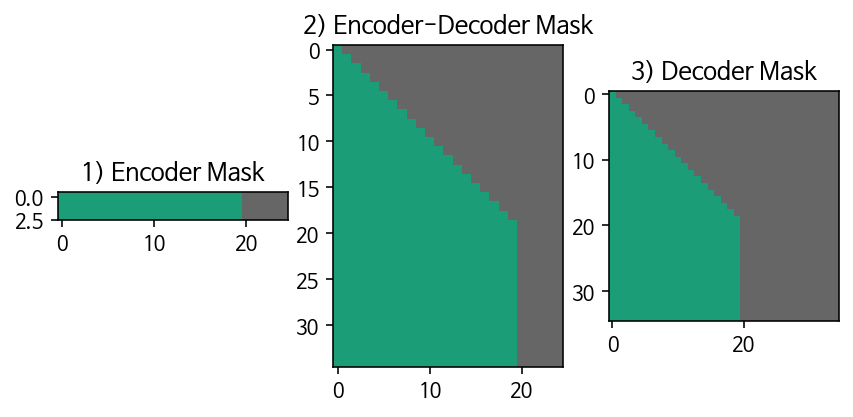

In [38]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

**generate_padding_mask()** 는 Attention을 할 때에 PAD 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다.

Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행합니다.

한 배치의 데이터에서 PAD 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다.


첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다.

낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다.

자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 하는 것과 관련하여, 인과 관계를 가리는 것도 중요하지만 Decoder 역시 PAD 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된다고 합니다.



Step 4. 훈련하기

---
앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, **예문에 대한 멋진 번역**을 제출하세요!

1. 2 Layer를 가지는 ```Transformer```를 선언하세요.<br>(하이퍼파라미터는 자유롭게 조절합니다.)

2. 논문에서 사용한 것과 동일한 **Learning Rate Scheduler**를 선언하고, 이를 포함하는 **Adam Optimizer**를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [39]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

3. **Loss 함수를 정의**하세요.<br> Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, **Masking 되지 않은 입력의 개수로 Scaling**하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [40]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. ```train_step``` **함수**를 정의하세요.<br> **입력 데이터에 알맞은 Mask를 생성**하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [42]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [43]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [44]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')
    
    print(len(_input))
    print(enc_train.shape[-1])

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        # InvalidArgumentError: In[0] mismatch In[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [Op:BatchMatMulV2]
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [45]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [46]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff = 2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared=True
)

5. **학습을 진행**합니다.<br> **매 Epoch 마다 제시된 예문에 대한 번역을 생성**하고, 멋진 번역이 생성되면 그때의 **하이퍼파라미터와 생성된 번역을 제출**하세요!


In [48]:
# 학습

## from tqdm import tqdm_notebook 
import random
from tqdm import tqdm_notebook  

BATCH_SIZE = 64
EPOCHS = 5

examples = [
            "1. 오바마는 대통령이다.",
            "2. 시민들은 도시 속에 산다.",
            "3. 커피는 필요 없다.",
            "4. 일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_1139/234158154.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1132 [00:00<?, ?it/s]

1
50
Input: 1. 오바마는 대통령이다.
Predicted translation: the president is a day of the president .
1
50
Input: 2. 시민들은 도시 속에 산다.
Predicted translation: the government has been a second place in the city of the city .
1
50
Input: 3. 커피는 필요 없다.
Predicted translation: the government is not to be a smaller .
1
50
Input: 4. 일곱 명의 사망자가 발생했다.
Predicted translation: the south korean people died in the city of the city , a police official said .


  0%|          | 0/1132 [00:00<?, ?it/s]

1
50
Input: 1. 오바마는 대통령이다.
Predicted translation: the year old is the first time .
1
50
Input: 2. 시민들은 도시 속에 산다.
Predicted translation: the city s city is the city of the city s city .
1
50
Input: 3. 커피는 필요 없다.
Predicted translation: the coffee is not a key .
1
50
Input: 4. 일곱 명의 사망자가 발생했다.
Predicted translation: the government has been killed .


  0%|          | 0/1132 [00:00<?, ?it/s]

1
50
Input: 1. 오바마는 대통령이다.
Predicted translation: the obama administration is the first person to the obama administration .
1
50
Input: 2. 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . .
1
50
Input: 3. 커피는 필요 없다.
Predicted translation: . coffee
1
50
Input: 4. 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed and people were wounded in the past two days .


  0%|          | 0/1132 [00:00<?, ?it/s]

1
50
Input: 1. 오바마는 대통령이다.
Predicted translation: . . . . . . . . . . . . . . . . . . . .
1
50
Input: 2. 시민들은 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
1
50
Input: 3. 커피는 필요 없다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
1
50
Input: 4. 일곱 명의 사망자가 발생했다.
Predicted translation: . . . . . . .


  0%|          | 0/1132 [00:00<?, ?it/s]

1
50
Input: 1. 오바마는 대통령이다.
Predicted translation: . president obama is the first president to be the first president .
1
50
Input: 2. 시민들은 도시 속에 산다.
Predicted translation: . . . . . . .
1
50
Input: 3. 커피는 필요 없다.
Predicted translation: . not eating the rest of the country
1
50
Input: 4. 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll was .


예문
```
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
```
에폭 1
```
the president is a day of the president .
the government has been a second place in the city of the city .
the government is not to be a smaller .
the south korean people died in the city of the city , a police official said .
```
에폭 2
```
the year old is the first time .
the city s city is the city of the city s city .
the coffee is not a key .
the government has been killed .
```
에폭 3
```
the obama administration is the first person to the obama administration .
. . . . . . .
coffee
the death toll was killed and people were wounded in the past two days .
```
에폭 4
```
. . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . .
```
에폭 5
```
president obama is the first president to be the first president .
. . . . . .
not eating the rest of the country
the death toll from the death toll was .
```





# 회고

## 열받아!!!!!!
👿😈👿👿👿👿👿👿👿👿👿👿👿👿

```OSError: Not found: unknown field name "수익금과" in TrainerSpec.```<br>
에러 이 에러 이망할 에러<br>
**sentencepiece**.....<br>
에러가 난 이유를 찾으려 해도 도저히 못찾았다. 구글을 온종일 뒤져봐도 비슷한건 안나왔기 때문이다.👿<br>
그래서 라이브러리 문제인가해서 버전도 다운그레이드했지만 안되었다.👿<br>

다른 사람 코드를 참고한 결과
```
# corpus를 받아 txt 파일로 저장
    temp_file = os.getenv('HOME') + f'/aiffel/transfomer/result/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
```

이부분이 없어서 에러가 났던 것 같다.<br>
프로젝트를 진행할 때 대강의 방향을 알려주지만 이부분은 따로 알려주지 않아서<br>
여전히 왜 저게 필요한건지<br>
저장을 안하면 노드 진행을 못하는 건지<br>
하


어이없어

❕ 그리고

어림없이 또 에러등장

```NameError: name 'tqdm_notebook' is not defined```<br>
노드에 주어진 코드는 이거였지만<br>
from tqdm.notebook import tqdm

따로 찾아봤더니 <br>
버전이 바뀌어서 tqdm에서는 tqdm_notebook이라는 명령어를 사용하지 못한다고 한다.<br>
그래서 위의 코드가 맞고 lms에서는 최신 버전이 아니라서 밑에 코드가 작동하는 것 같다

from tqdm import tqdm_notebook




>## **루브릭**
>
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
>|2|Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
>|3|테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|